In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! zip -s- "/content/drive/My Drive/Praj/plant-seedlings-classification.zip" -O plant-seedlings-classification.zip
! unzip plant-seedlings-classification.zip -d plant-seedlings-classification

Streaming output truncated to the last 5000 lines.
  inflating: plant-seedlings-classification/test/b1cd2a91e.png  
  inflating: plant-seedlings-classification/test/b215531dd.png  
  inflating: plant-seedlings-classification/test/b2706e2b3.png  
  inflating: plant-seedlings-classification/test/b29339405.png  
  inflating: plant-seedlings-classification/test/b30ab4659.png  
  inflating: plant-seedlings-classification/test/b31292706.png  
  inflating: plant-seedlings-classification/test/b341d0aab.png  
  inflating: plant-seedlings-classification/test/b39c71707.png  
  inflating: plant-seedlings-classification/test/b3d6fdb80.png  
  inflating: plant-seedlings-classification/test/b3e08b037.png  
  inflating: plant-seedlings-classification/test/b47691c08.png  
  inflating: plant-seedlings-classification/test/b4c3df835.png  
  inflating: plant-seedlings-classification/test/b4f7c9214.png  
  inflating: plant-seedlings-classification/test/b573b7a56.png  
  inflating: plant-seedlings-classifica

In [ ]:
import os
import warnings
warnings.filterwarnings("ignore")

labels = os.listdir("plant-seedlings-classification/train")
print(labels)

['Common wheat', 'Shepherds Purse', 'Cleavers', 'Loose Silky-bent', 'Scentless Mayweed', 'Small-flowered Cranesbill', 'Sugar beet', 'Maize', 'Fat Hen', 'Black-grass', 'Charlock', 'Common Chickweed']


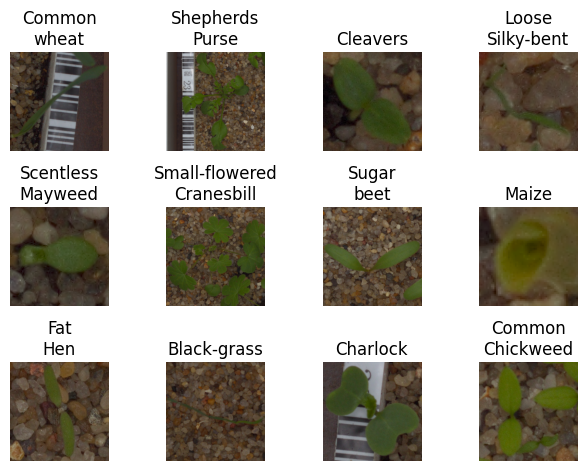

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image


fig, axs = plt.subplots(nrows=3, ncols=4)
fig.tight_layout()
for index, label in enumerate(labels):
    image = np.random.choice(os.listdir(f"plant-seedlings-classification/train/{label}"))
    im = Image.open(f"plant-seedlings-classification/train/{label}/{image}")
    ind = int(index/4), index % 4
    axs[ind].imshow(im)
    axs[ind].set_title(label.replace(" ", "\n"))
    axs[ind].axis("off")

In [ ]:
from fastai.vision.all import *
from fastai.metrics import accuracy

# Use from_folder factory method from ImageDataBunch to create a dataset
# configure:
#   path
#   size
#   ds_tfms, to flip the image randomly and allow fliping vertically
#   valid_pct， 20%

path = "plant-seedlings-classification/train"
size = 224
ds_tfms = aug_transforms(do_flip=True, flip_vert=True, max_rotate=30.0)
valid_pct = 0.2
data = ImageDataLoaders.from_folder(path, train=".", valid_pct=valid_pct, item_tfms=Resize(size), batch_tfms=ds_tfms)

In [ ]:
# normalize with imagenet_stats
normalize = Normalize.from_stats(*imagenet_stats)

In [ ]:
# create a CNN learner named "learner" with resnet34
learner = cnn_learner(data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:01<00:00, 45.2MB/s]


SuggestedLRs(valley=0.0010000000474974513)

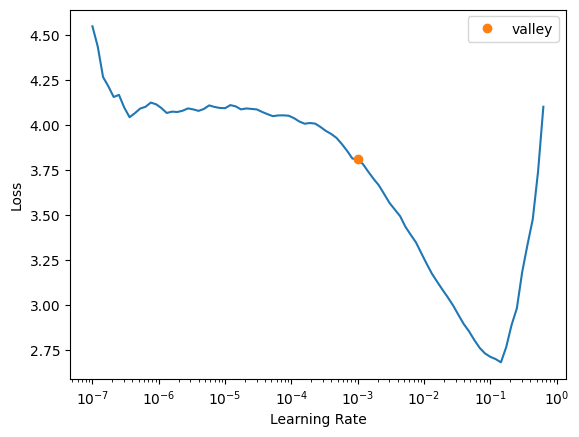

In [ ]:
# find a learning rate
learner.lr_find()

In [ ]:
# fit one cycle
learner.fit_one_cycle(5, lr_max=0.0010000000474974513)

epoch,train_loss,valid_loss,accuracy,time
0,2.707153,1.143682,0.644211,01:03
1,1.417298,0.507763,0.820000,01:00
2,0.852351,0.386016,0.872632,01:01
3,0.613004,0.341171,0.872632,00:59
4,0.520505,0.331631,0.880000,00:59


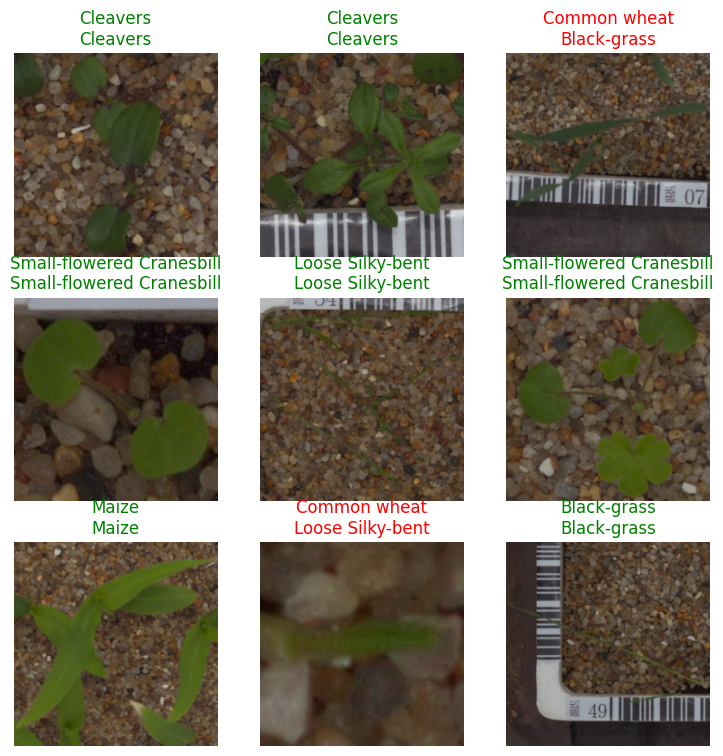

In [ ]:
learner.show_results()

In [ ]:
# interpret the result and see the most confused classess
interp = ClassificationInterpretation.from_learner(learner)
interp.most_confused(min_val=2)

[('Loose Silky-bent', 'Black-grass', 23),
 ('Black-grass', 'Loose Silky-bent', 16),
 ('Common Chickweed', 'Fat Hen', 8),
 ('Shepherds Purse', 'Scentless Mayweed', 6),
 ('Fat Hen', 'Sugar beet', 4),
 ('Common wheat', 'Black-grass', 3),
 ('Fat Hen', 'Common wheat', 3),
 ('Loose Silky-bent', 'Common wheat', 3),
 ('Scentless Mayweed', 'Loose Silky-bent', 3),
 ('Scentless Mayweed', 'Shepherds Purse', 3),
 ('Sugar beet', 'Fat Hen', 3),
 ('Black-grass', 'Common wheat', 2),
 ('Common Chickweed', 'Scentless Mayweed', 2),
 ('Common Chickweed', 'Shepherds Purse', 2),
 ('Common wheat', 'Loose Silky-bent', 2),
 ('Maize', 'Common wheat', 2),
 ('Scentless Mayweed', 'Cleavers', 2),
 ('Sugar beet', 'Cleavers', 2)]

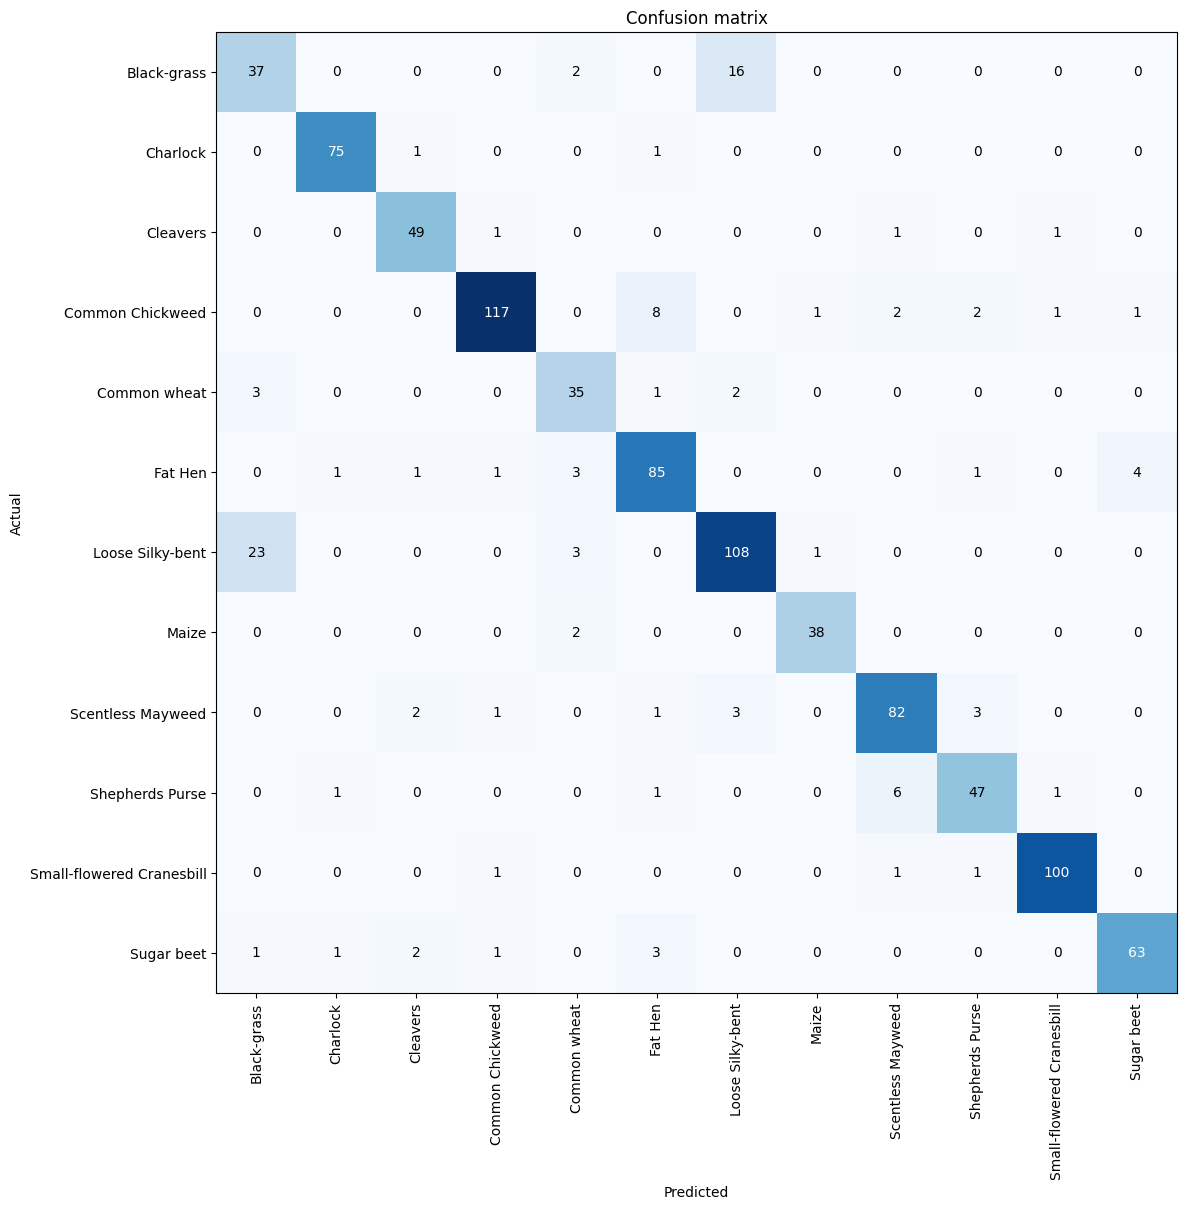

In [ ]:
#plot confusion matrix
interp.plot_confusion_matrix(figsize=(12,12))

SuggestedLRs(valley=0.00363078061491251)

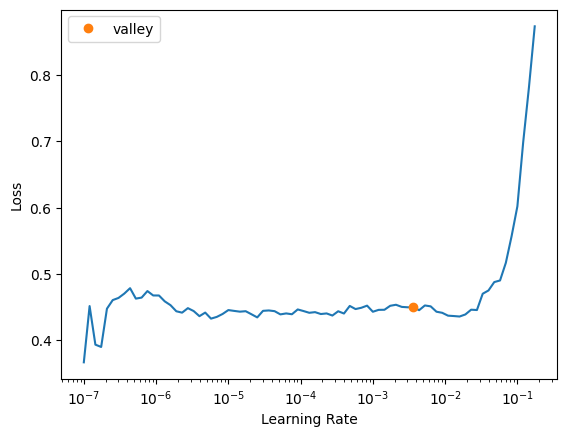

In [ ]:
learner.lr_find()

In [ ]:
# fine tune the model and check the result again
learner.unfreeze()
learner.fit_one_cycle(5, lr_max=0.00363078061491251)

epoch,train_loss,valid_loss,accuracy,time
0,1.212990,52.065258,0.164211,01:03
1,0.999755,1.475438,0.557895,01:01
2,0.693125,0.610736,0.795789,01:02
3,0.438260,0.263608,0.912632,01:00
4,0.300555,0.185384,0.931579,01:06


In [ ]:
interp_after_fine_tune = ClassificationInterpretation.from_learner(learner)
interp.most_confused(min_val=2)

[('Black-grass', 'Loose Silky-bent', 25),
 ('Loose Silky-bent', 'Black-grass', 11),
 ('Black-grass', 'Common wheat', 4),
 ('Black-grass', 'Sugar beet', 2),
 ('Cleavers', 'Scentless Mayweed', 2),
 ('Fat Hen', 'Charlock', 2),
 ('Fat Hen', 'Common Chickweed', 2),
 ('Fat Hen', 'Common wheat', 2),
 ('Scentless Mayweed', 'Shepherds Purse', 2),
 ('Shepherds Purse', 'Scentless Mayweed', 2),
 ('Sugar beet', 'Common Chickweed', 2)]

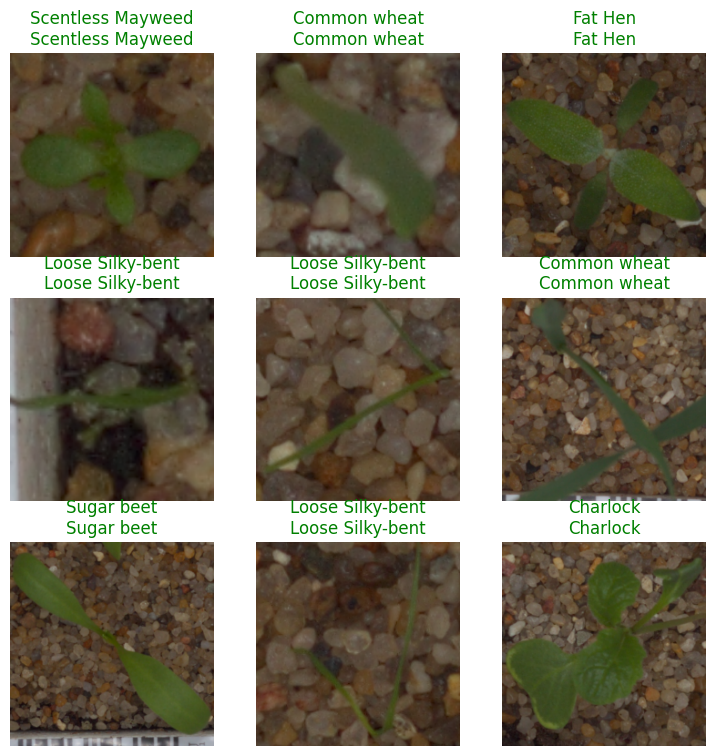

In [ ]:
learner.show_results()

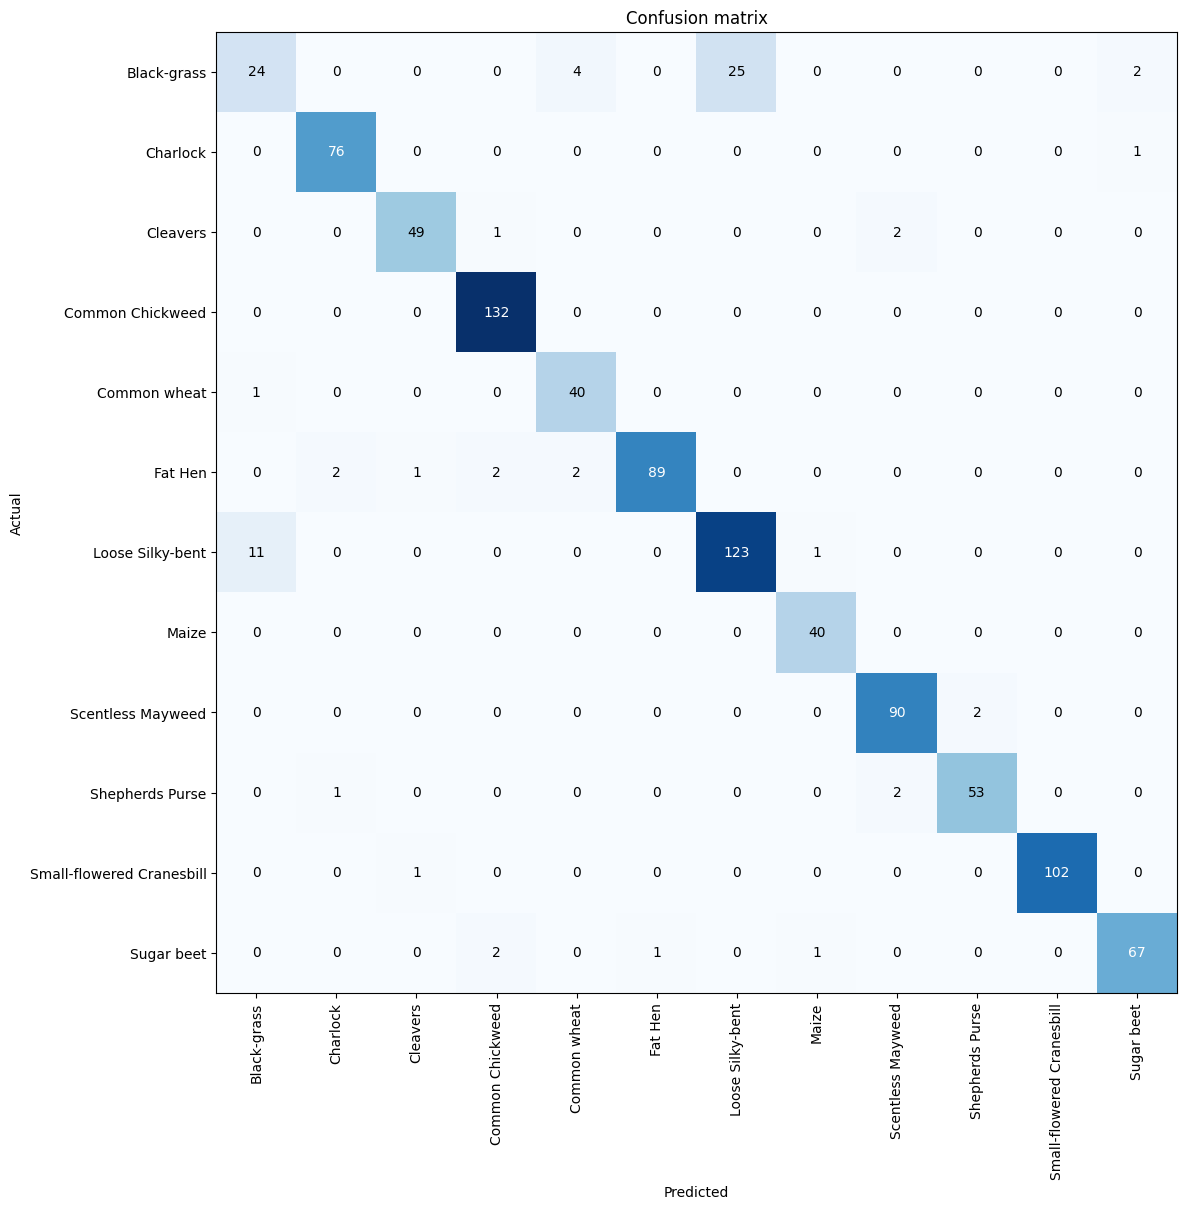

In [ ]:
interp_after_fine_tune.plot_confusion_matrix(figsize=(12,12))

In [ ]:
print("Accuracy:", learner.validate())

Accuracy: [0.18538352847099304, 0.9315789341926575]


In [ ]:
learner.export("/content/drive/My Drive/Praj/plant_seedlings_classifier.pkl")